In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import s3fs
import warnings
warnings.filterwarnings('ignore')

In [3]:
# df = pd.read_parquet("../data/Silver/eda_cleaned_HI-Medium_Trans.parquet")
df = pd.read_parquet("s3://bass-risk-monitoring/Silver/eda_cleaned_HI-Medium_Trans.parquet")

In [4]:
df.shape

(31898238, 19)

In [5]:
df.dtypes

Timestamp              datetime64[ns]
From Bank                       int32
Account                string[python]
To Bank                         int32
Account.1              string[python]
Amount Received               float64
Receiving Currency           category
Amount Paid                   float64
Payment Currency             category
Payment Format               category
Is Laundering                    int8
log_amount_paid               float64
log_amount_received           float64
hour                            int32
date                           object
month                       period[M]
day_of_week                     int32
is_weekend                      int64
daily_txn_count                 int64
dtype: object

In [6]:
df.columns  

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'daily_txn_count'],
      dtype='object')

### Feature engineering

Temporal Feature Engineering

In [8]:
# time since last txn (sec) per account
df = df.sort_values(['Account', 'Timestamp']).reset_index(drop=True)

df['time_since_last_txn'] = (
    df.groupby('Account')['Timestamp']
      .diff()
      .dt.total_seconds()
      .fillna(0)
)


In [9]:

# rolling 24h count per account
df['_ones'] = 1
temp = (
    df.set_index('Timestamp')                
      .groupby('Account')['_ones']          
      .rolling('1D')                         
      .sum()                                 # aggregate sum of 1's
      .astype('int32')                       
      .reset_index(level=0, drop=True)     
)


In [10]:
# index to time
df = df.set_index('Timestamp')
df['txn_count_24h'] = temp
df = df.reset_index()


In [11]:
# 24h activity excluding current row
df['txn_count_24h_excl'] = (df['txn_count_24h'] - 1).astype('int32')

# clean helper column
df.drop(columns=['_ones'], inplace=True, errors='ignore')
print("After temporal feats:", df.shape)


After temporal feats: (31898238, 22)


In [12]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'daily_txn_count', 'time_since_last_txn',
       'txn_count_24h', 'txn_count_24h_excl'],
      dtype='object')

Behavioral Feature Engineering

In [13]:
# ramount atios
df['amount_ratio'] = df['Amount Paid'] / (df['Amount Received'] + 1e-6)

# diversity on Currency and payment format per account
currency_div = df.groupby('Account')['Payment Currency'].nunique().rename('currency_diversity')
format_div   = df.groupby('Account')['Payment Format']  .nunique().rename('format_diversity')


In [14]:
df = df.merge(currency_div, on='Account', how='left')
df = df.merge(format_div,   on='Account', how='left')

print("After behavioral feats:", df.shape)


After behavioral feats: (31898238, 25)


In [15]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering',
       'log_amount_paid', 'log_amount_received', 'hour', 'date', 'month',
       'day_of_week', 'is_weekend', 'daily_txn_count', 'time_since_last_txn',
       'txn_count_24h', 'txn_count_24h_excl', 'amount_ratio',
       'currency_diversity', 'format_diversity'],
      dtype='object')

Network / Relational Feature Engineering

In [16]:
# unique receivers per sender and unique senders per receiver 
counter_from = df.groupby('Account')['To Bank'].nunique().rename('unique_receivers')
counter_to = df.groupby('Account.1')['From Bank'].nunique().rename('unique_senders')


In [17]:
# N/W features to df
df = df.merge(counter_from, on='Account', how='left')
df = df.merge(counter_to, left_on='Account', right_index=True, how='left')


In [18]:
# circular/self transfer flag
df['is_self_transfer'] = (df['Account'] == df['Account.1']).astype('int8')

print("After network feats:", df.shape)


After network feats: (31898238, 28)


Correlation Analysis

In [23]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric features detected: {len(num_cols)}")

Numeric features detected: 20


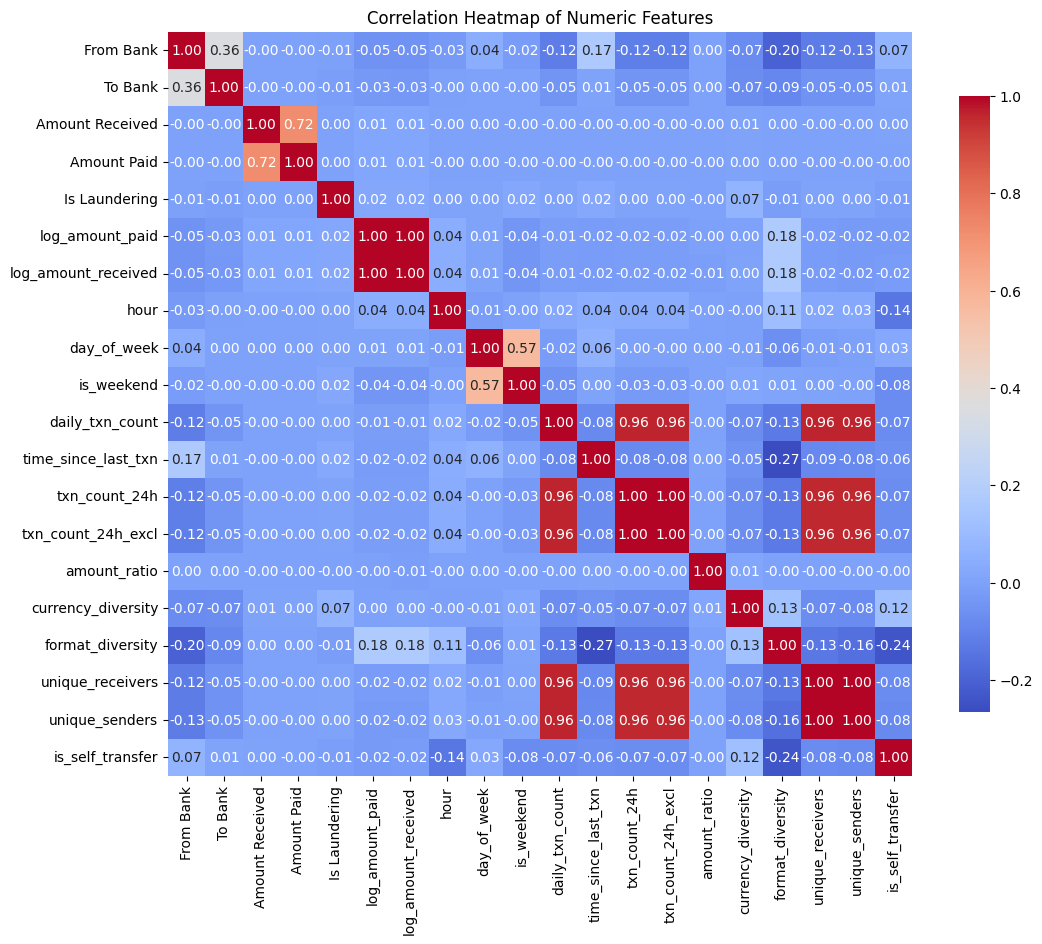

In [24]:
# Correlation coefficients > 0.85 or < -0.85 are  redundant or linearly dependent.
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


Highly Correlated Features (|r| > 0.85)

In [25]:
threshold = 0.85
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
higly_corr = [col for col in upper.columns if any(upper[col].abs() > threshold)]

print("Highly correlated to drop:", higly_corr)


Highly correlated to drop: ['log_amount_received', 'txn_count_24h', 'txn_count_24h_excl', 'unique_receivers', 'unique_senders']


Dropping all of them will remove signals tied to temporal or transactional patterns, we keep  features that preserve the behavioral insights.

In [28]:
to_keep = {
    'txn_count_24h_excl',
    'unique_receivers',
}

to_drop_final = {
    'log_amount_received',   
    'txn_count_24h',        
    'unique_senders',       
}

In [30]:

df_reduced = df.drop(columns=list(to_drop_final), errors='ignore')
print(f"Remaining columns: {len(df_reduced.columns)}")
df_reduced.shape

Remaining columns: 25


(31898238, 25)

In [ ]:
df_reduced.to_parquet("../data/Silver/df_reduced.parquet", index=False)